In [53]:
import pandas as pd
df = pd.read_csv('/home/kcv/Desktop/constant_power_test/stitched_detail_data/RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv')
df.columns

Index(['source_file', 'sheet_name', 'Record number', 'Sequence number of step',
       'Cycle No', 'Step No', 'Step name', 'Absolute time', 'Record time(m)',
       'Step time(h:m:s.ms)', 'volt(V)', 'Current(A)', 'Capacity(Ah)',
       'Energy(Wh)', 'Power(mW)', 'Internal R(Ω)', 'Charging energy(Wh)',
       'Discharge energy(Wh)', 'Charging capacity(Ah)',
       'Discharge capacity(Ah)', 'CUM charge E(Wh)', 'CUM discharge E(Wh)',
       'CUM charge C(Ah)', 'CUM discharge C(Ah)', 'Chamber T(℃)',
       'Chamber H(%)', 'Ripple F(Hz)', 'Ripple current(A)',
       'Total capacity(Ah)', 'DischargeVolt(V)', 'DischargeCurrent(A)',
       'DischargePower(mW)', 'water chiller outlet pressure(bar)',
       'water chiller return water pressure(bar)',
       'water chiller set flow(L/min)', 'water chiller set temperature(℃)',
       'Current water chiller temperature(℃)',
       'Current water chiller flow rate(L/min)', 'water chiller status',
       'water chiller mode', 'water chiller return wa

In [ ]:
df[['Cycle No', 'Step name', 'Step No']].drop_duplicates()

In [62]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/constant_power_test/stitched_detail_data")
OUTPUT = Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")

summaries = []

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    df = pd.read_csv(csv_path)

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df["Current_abs_A"] = df["Current(A)"].abs().round(2)
    df["Capacity_abs_Ah"] = df["Capacity(Ah)"].abs()
    df["Power_W"] = df["Power(mW)"].abs() / 1000
    df["Energy(Wh)"] = df["Energy(Wh)"].abs()

    df = df.sort_values(["Cycle No", "Absolute time", "Step No"])

    durations = (
        df.groupby(["Cycle No", "Step name", "Step No"], dropna=False)
        .agg(
            Start=("Absolute time", "min"),
            End=("Absolute time", "max"),
            Current_min=("Current_abs_A", "min"),
            Current_max=("Current_abs_A", "max"),
            Current_initial=("Current_abs_A", "first"),
            Current_final=("Current_abs_A", "last"),
            Capacity_min=("Capacity_abs_Ah", "min"),
            Capacity_max=("Capacity_abs_Ah", "max"),
            Volt_min=("volt(V)", "min"),
            Volt_max=("volt(V)", "max"),
            Volt_mean=("volt(V)", "mean"),
            Power_min_W=("Power_W", "min"),
            Power_max_W=("Power_W", "max"),
            Energy_mean_Wh=("Energy(Wh)", "mean"),
        )
    )

    durations["Duration_s"] = (durations["End"] - durations["Start"]).dt.total_seconds().round()
    durations["c_rate"] = (durations["Current_max"] / 150).round(2)
    durations["Current_drop_A"] = (durations["Current_initial"] - durations["Current_final"]).abs().round(5)

    summary = durations.reset_index()
    summary.insert(0, "Cell", csv_path.stem)
    summaries.append(summary)

eda_summary = pd.concat(summaries, ignore_index=True)
eda_summary.to_csv(OUTPUT, index=False)
print(f"Saved summary for {len(summaries)} cells to {OUTPUT}")


Saved summary for 21 cells to /home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv


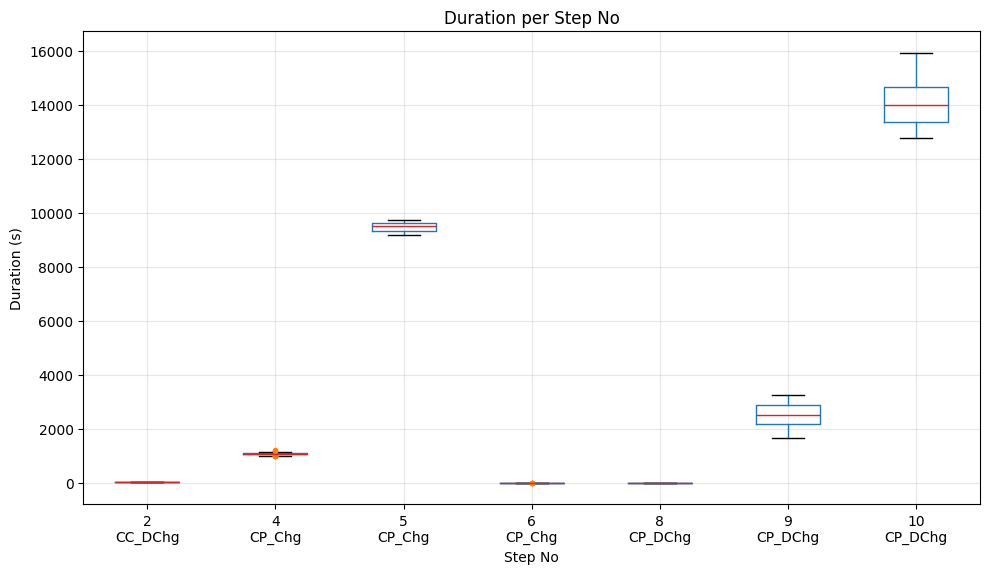

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)
summary = summary[summary["Step name"].str.lower() != "rest"]

# Keep one label per step with the observed step name(s)
step_name_map = (
    summary.groupby("Step No")["Step name"]
    .agg(lambda s: ", ".join(dict.fromkeys(s)))
    .sort_index()
)

fig, ax = plt.subplots(figsize=(10, 6))
summary.boxplot(
    column="Duration_s",
    by="Step No",
    ax=ax,
    boxprops=dict(color="tab:blue"),
    medianprops=dict(color="tab:red"),
    flierprops=dict(marker="o", markerfacecolor="tab:orange", markersize=4, markeredgecolor="none"),
)

ax.set_title("Duration per Step No")
ax.set_xlabel("Step No")
ax.set_ylabel("Duration (s)")
ax.grid(alpha=0.3)

# Annotate each x tick with the step name under the step number
labels = [f"{step_no}\n{step_name_map.loc[step_no]}" for step_no in step_name_map.index]
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)

plt.suptitle("")
plt.tight_layout()
plt.show()


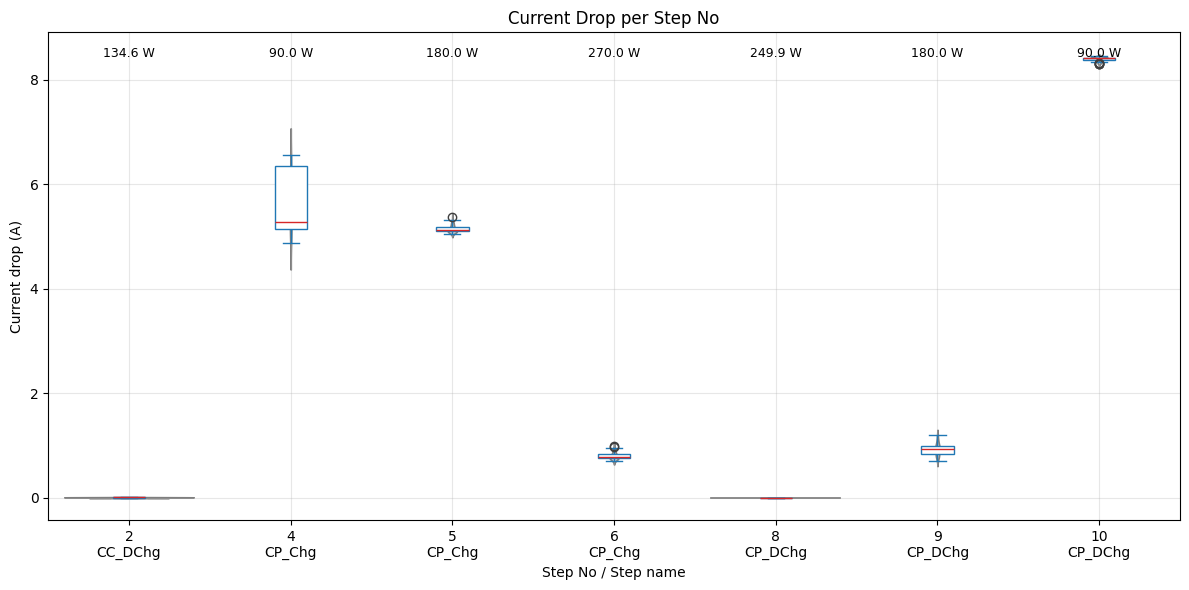

In [63]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)
summary = summary[summary["Step name"].str.lower() != "rest"]
summary = summary[pd.notna(summary["Current_drop_A"])]

step_name_map = (
    summary.groupby("Step No")["Step name"]
    .agg(lambda s: ", ".join(dict.fromkeys(s)))
    .sort_index()
)

avg_max_power = (
    summary.groupby("Step No")["Power_max_W"]
    .mean()
    .reindex(step_name_map.index)
)

summary["Step label"] = summary["Step No"].apply(lambda x: f"{int(x)}\n{step_name_map.loc[x]}")

plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=summary,
    x="Step label",
    y="Current_drop_A",
    inner=None,
    color="lightgray",
)
sns.boxplot(
    data=summary,
    x="Step label",
    y="Current_drop_A",
    width=0.2,
    showcaps=True,
    boxprops={"facecolor": "white", "edgecolor": "tab:blue"},
    medianprops={"color": "tab:red"},
    whiskerprops={"color": "tab:blue"},
    capprops={"color": "tab:blue"},
)

ax.set_title("Current Drop per Step No")
ax.set_xlabel("Step No / Step name")
ax.set_ylabel("Current drop (A)")
ax.grid(alpha=0.3)

ylim = ax.get_ylim()
y_offset = (ylim[1] - ylim[0]) * 0.03
for idx, power in enumerate(avg_max_power, start=0):
    if pd.notna(power):
        ax.text(idx, ylim[1] - y_offset, f"{power:.1f} W", ha="center", va="top", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)
summary = summary[summary["Step name"].str.lower() != "rest"]
summary = summary[pd.notna(summary["Current_drop_A"])]

summary["Cell ID"] = summary["Cell"].str.split("_").str[-3]
summary["Step label"] = summary["Step No"].astype(int).astype(str)

# collapse multiple cycles per cell/step
collapsed = (
    summary.groupby(["Step label", "Step name", "Cell ID"], as_index=False)
    .agg(
        Current_drop_A=("Current_drop_A", "mean"),
        Power_max_W=("Power_max_W", "mean"),
    )
)

output_pdf = Path("/home/kcv/Desktop/constant_power_test/post_processing/plots/current_drop_per_step_sorted.pdf")
output_pdf.parent.mkdir(parents=True, exist_ok=True)

with PdfPages(output_pdf) as pdf:
    for (step_label, step_name), group in collapsed.groupby(["Step label", "Step name"]):
        group = group.sort_values("Current_drop_A", ascending=False).copy()
        drops = group["Current_drop_A"].values
        local_norm = plt.Normalize(drops.min(), drops.max())
        cmap = plt.cm.magma
        colors = cmap(local_norm(drops))

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(group["Cell ID"], drops, color=colors, alpha=0.9)
        ax.set_xlabel("Cell ID")
        ax.set_ylabel("Current drop (A)")
        ax.set_title(f"Step {step_label} — {step_name}")
        ax.grid(axis="y", alpha=0.3)

        ax.set_xticklabels(group["Cell ID"], rotation=90, ha="center")

        mean_drop = group["Current_drop_A"].mean()
        ax.axhline(mean_drop, color="tab:green", linestyle="--", linewidth=1.2, label=f"Mean drop {mean_drop:.2f} A")

        mean_power = group["Power_max_W"].mean()
        ax.text(
            0.98,
            0.92,
            f"Avg max power: {mean_power:.1f} W",
            transform=ax.transAxes,
            ha="right",
            va="center",
            fontsize=9,
            color="tab:green",
        )



        sm = plt.cm.ScalarMappable(cmap=cmap, norm=local_norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, pad=0.02, label="Current drop (A)")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved step-wise plots to {output_pdf}")


/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_267305/4285887689.py:44: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

Saved step-wise plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/current_drop_per_step_sorted.pdf


In [9]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/constant_power_test/stitched_detail_data")
OUTPUT_DIR = Path("/home/kcv/Desktop/constant_power_test/post_processing/data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_COLUMNS = [
    "Cycle No",
    "Step No",
    "Step name",
    "Absolute time",
    "Record time(m)",
    "Step time(h:m:s.ms)",
    "volt(V)",
    "Current(A)",
    "Capacity(Ah)",
    "Energy(Wh)",
    "Power(mW)",
    "c-rate",
    "duration",
]

for csv_path in DATA_DIR.glob("*.csv"):
    df = pd.read_csv(csv_path)

    if not {"Absolute time", "Current(A)", "Cycle No", "Step No", "Step name"} <= set(df.columns):
        raise ValueError(f"{csv_path.name} is missing required source columns.")

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")

    df["c-rate"] = (df["Current(A)"].abs() / 150).round(2)

    df["duration"] = (
        df.groupby(["Cycle No", "Step No", "Step name"])["Absolute time"]
          .transform(lambda s: (s.max() - s.min()).total_seconds())
    )

    missing = [col for col in REQUIRED_COLUMNS if col not in df.columns]
    if missing:
        raise ValueError(f"{csv_path.name} lacks columns: {', '.join(missing)}")

    df = df[REQUIRED_COLUMNS]
    df.to_csv(OUTPUT_DIR / csv_path.name, index=False)
    print(f"Saved {csv_path.name} with c-rate and duration.")


Saved RD_LFP_ConstantPower_REPT_TS_150_0050_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0003_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0004_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0025_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0065_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0057_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0040_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0007_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0046_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0043_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0078_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0

In [1]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("Power(mW)",),   # note the tuple
    output_filename="chg_dchg_power_vs_time.pdf",
)


Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf')

In [2]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("volt(V)","Current(A)"),   # note the tuple
    output_filename="chg_dchg_voltage_current_vs_time.pdf",
)

Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_current_vs_time.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_current_vs_time.pdf')

In [1]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="volt(V)",
    y_fields=("Power(mW)",),   # note the tuple
    output_filename="chg_dchg_voltage_vs_power.pdf",
)

Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_vs_power.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_vs_power.pdf')

# Identify the power transition levels 

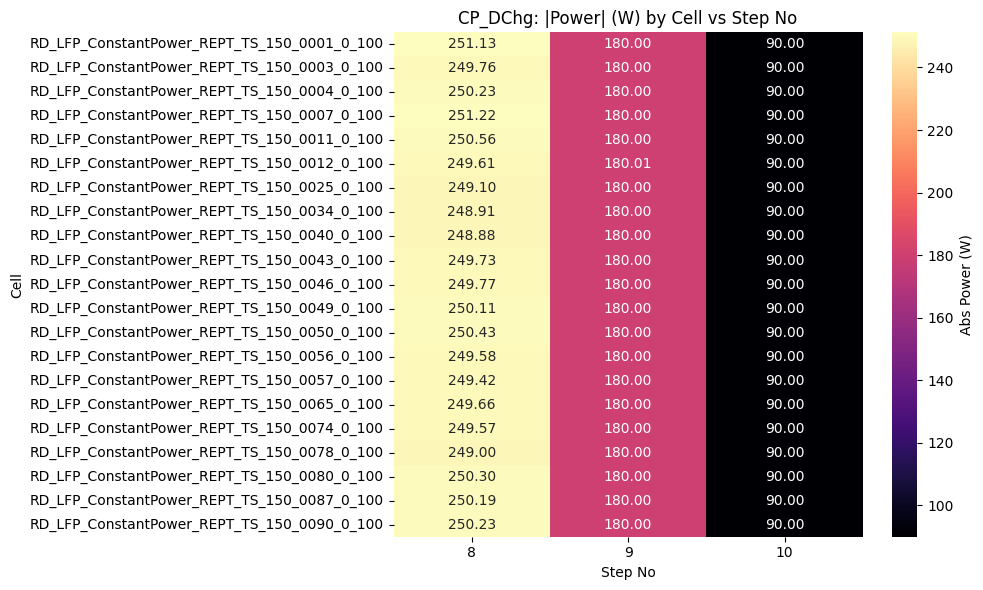

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

summary_path = Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
summary = pd.read_csv(summary_path)

cp_dchg = summary[summary["Step name"] == "CP_DChg"].copy()
cp_dchg["abs_power_W"] = cp_dchg[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

pivot = cp_dchg.pivot_table(
    index="Cell",
    columns="Step No",
    values="abs_power_W",
    aggfunc="mean",
    fill_value=0,
).sort_index()

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="magma",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Abs Power (W)"},
)
plt.title("CP_DChg: |Power| (W) by Cell vs Step No")
plt.xlabel("Step No")
plt.ylabel("Cell")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from pathlib import Path

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)

cp_steps = summary[summary["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
cp_steps["abs_power_W"] = cp_steps[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

def expected_power(row):
    vmin, vmax = row["Volt_min"], row["Volt_max"]
    name = row["Step name"]

    if name == "CP_Chg":
        if vmax <= 3.25:
            return 90
        if vmin >= 3.25 and vmax <= 3.6:
            return 180
        if vmin >= 3.6:
            return 270
    elif name == "CP_DChg":
        if vmin >= 3.6:
            return 270
        if vmin >= 3.25 and vmax <= 3.6:
            return 180
        if vmin < 3.25 and vmax <= 3.25 and vmin >= 2.5:
            return 90
    return None  # spans multiple regions or doesn’t match rules

cp_steps["expected_power_W"] = cp_steps.apply(expected_power, axis=1)
cp_steps["power_error_W"] = cp_steps["abs_power_W"] - cp_steps["expected_power_W"]

tolerance = 5  # adjust as needed
violations = cp_steps[
    cp_steps["expected_power_W"].notna() & (cp_steps["power_error_W"].abs() > tolerance)
]

display(
    cp_steps[
        [
            "Cell",
            "Cycle No",
            "Step No",
            "Step name",
            "Volt_min",
            "Volt_max",
            "abs_power_W",
            "expected_power_W",
            "power_error_W",
        ]
    ]
)

display(violations)  # steps that differ from spec beyond tolerance


,Cell,Cycle No,Step No,Step name,Volt_min,Volt_max,abs_power_W,expected_power_W,power_error_W
1,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,4,CP_Chg,2.636974,3.250000,90.011301,90.0,0.011301
2,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,5,CP_Chg,3.260717,3.600010,180.001034,NaN,NaN
3,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,6,CP_Chg,3.601500,3.650008,270.033686,270.0,0.033686
4,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,8,CP_DChg,3.331102,3.331102,251.498224,180.0,71.498224
5,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,9,CP_DChg,3.250000,3.298147,180.000586,180.0,0.000586
...,...,...,...,...,...,...,...,...,...
560,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,5,CP_Chg,3.266687,3.600003,180.000057,NaN,NaN
561,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,6,CP_Chg,3.610323,3.650049,270.030136,270.0,0.030136
562,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,8,CP_DChg,3.301529,3.301529,249.265331,180.0,69.265331
563,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,9,CP_DChg,3.250000,3.307453,180.000512,180.0,0.000512


,Cell,Cycle No,Step name,Step No,Start,End,Current_min,Current_max,Capacity_min,Capacity_max,Volt_min,Volt_max,Power_min_W,Power_max_W,Duration_s,c_rate,abs_power_W,expected_power_W,power_error_W
4,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_DChg,8,2025-11-26 16:21:46.063,2025-11-26 16:21:46.063,75.5,75.5,0.0,0.000,3.331102,3.331102,251.498224,251.498224,0.0,0.5,251.498224,180.0,71.498224
14,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,2,CP_DChg,8,2025-11-27 00:55:28.994,2025-11-27 00:55:28.994,75.5,75.5,0.0,0.001,3.330105,3.330105,251.423117,251.423117,0.0,0.5,251.423117,180.0,71.423117
22,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,3,CP_DChg,8,2025-11-27 09:31:56.432,2025-11-27 09:31:56.432,75.5,75.5,0.0,0.001,3.317604,3.317604,250.479241,250.479241,0.0,0.5,250.479241,180.0,70.479241
31,RD_LFP_ConstantPower_REPT_TS_150_0003_0_100,1,CP_DChg,8,2025-11-26 16:22:36.397,2025-11-26 16:22:36.397,75.5,75.5,0.0,0.000,3.307443,3.307443,249.711708,249.711708,0.0,0.5,249.711708,180.0,69.711708
41,RD_LFP_ConstantPower_REPT_TS_150_0003_0_100,2,CP_DChg,8,2025-11-27 00:52:59.482,2025-11-27 00:52:59.482,75.5,75.5,0.0,0.001,3.307199,3.307199,249.693310,249.693310,0.0,0.5,249.693310,180.0,69.693310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,RD_LFP_ConstantPower_REPT_TS_150_0087_0_100,2,CP_DChg,8,2025-11-27 01:01:54.134,2025-11-27 01:01:54.134,75.5,75.5,0.0,0.001,3.315752,3.315752,250.339213,250.339213,0.0,0.5,250.339213,180.0,70.339213
535,RD_LFP_ConstantPower_REPT_TS_150_0087_0_100,3,CP_DChg,8,2025-11-27 09:41:56.396,2025-11-27 09:41:56.396,75.5,75.5,0.0,0.001,3.320442,3.320442,250.693261,250.693261,0.0,0.5,250.693261,180.0,70.693261
544,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,1,CP_DChg,8,2025-11-26 16:17:35.721,2025-11-26 16:17:35.721,75.5,75.5,0.0,0.001,3.331480,3.331480,251.526457,251.526457,0.0,0.5,251.526457,180.0,71.526457
554,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,2,CP_DChg,8,2025-11-27 00:47:18.507,2025-11-27 00:47:18.507,75.5,75.5,0.0,0.001,3.310062,3.310062,249.909453,249.909453,0.0,0.5,249.909453,180.0,69.909453


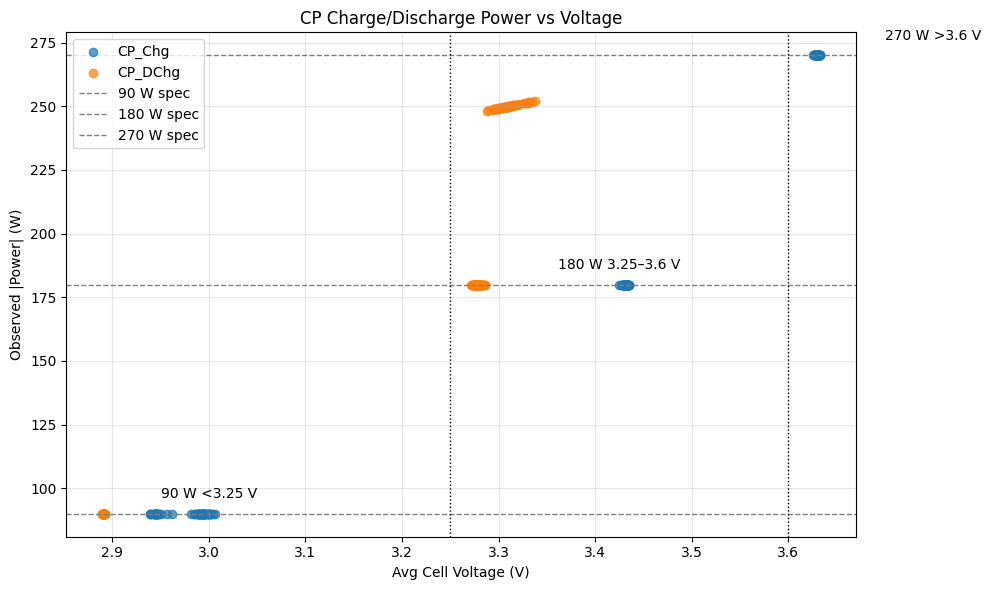

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

summary = pd.read_csv(Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv"))
cp = summary[summary["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
cp["abs_power_W"] = cp[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

colors = {"CP_Chg": "tab:blue", "CP_DChg": "tab:orange"}
for step_name, group in cp.groupby("Step name"):
    ax.scatter(
        (group["Volt_min"] + group["Volt_max"]) / 2,
        group["abs_power_W"],
        c=colors[step_name],
        label=step_name,
        alpha=0.7,
    )

ax.axhline(90, color="gray", linestyle="--", linewidth=1, label="90 W spec")
ax.axhline(180, color="gray", linestyle="--", linewidth=1, label="180 W spec")
ax.axhline(270, color="gray", linestyle="--", linewidth=1, label="270 W spec")
ax.axvline(3.25, color="k", linestyle=":", linewidth=1)
ax.axvline(3.6, color="k", linestyle=":", linewidth=1)

ax.text(3.0, 95, "90 W <3.25 V", ha="center", va="bottom")
ax.text(3.425, 185, "180 W 3.25–3.6 V", ha="center", va="bottom")
ax.text(3.75, 275, "270 W >3.6 V", ha="center", va="bottom")

ax.set_xlabel("Avg Cell Voltage (V)")
ax.set_ylabel("Observed |Power| (W)")
ax.set_title("CP Charge/Discharge Power vs Voltage")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

output_dir = Path("/home/kcv/Desktop/constant_power_test/post_processing/plots")
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / "cp_power_vs_voltage.png", dpi=300)



In [25]:
cp

,Cell,Cycle No,Step name,Step No,Start,End,Current_min,Current_max,Capacity_min,Capacity_max,Volt_min,Volt_max,Power_min_W,Power_max_W,Duration_s,c_rate,abs_power_W
1,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_Chg,4,2025-11-26 12:55:08.463,2025-11-26 13:13:04.817,27.69,34.13,0.0,8.716,2.636974,3.250000,89.995326,90.011301,1076.0,0.23,90.011301
2,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_Chg,5,2025-11-26 13:13:04.837,2025-11-26 15:51:41.813,50.00,55.20,0.0,140.288,3.260717,3.600010,179.993625,180.001034,9517.0,0.37,180.001034
5,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_DChg,9,2025-11-26 16:21:46.095,2025-11-26 17:03:04.179,54.58,55.38,0.0,38.048,3.250000,3.298147,179.992140,180.000586,2478.0,0.37,180.000586
6,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_DChg,10,2025-11-26 17:03:04.209,2025-11-26 20:58:49.059,27.40,36.00,0.0,110.551,2.499979,3.284031,89.986281,90.000659,14145.0,0.24,90.000659
11,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,2,CP_Chg,4,2025-11-26 21:28:49.360,2025-11-26 21:46:37.332,27.69,32.90,0.0,8.612,2.735144,3.250000,89.995219,90.004516,1068.0,0.22,90.004516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,2,CP_DChg,10,2025-11-27 01:19:47.753,2025-11-27 05:27:13.717,27.40,35.99,0.0,115.946,2.499988,3.284279,89.985676,90.000531,14846.0,0.24,90.000531
559,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,CP_Chg,4,2025-11-27 05:57:13.612,2025-11-27 06:14:13.698,27.69,32.81,0.0,8.233,2.743337,3.250001,89.995136,90.005146,1020.0,0.22,90.005146
560,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,CP_Chg,5,2025-11-27 06:14:13.719,2025-11-27 08:49:57.830,50.00,55.10,0.0,137.796,3.266687,3.600003,179.993468,180.000057,9344.0,0.37,180.000057
563,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,CP_DChg,9,2025-11-27 09:20:01.820,2025-11-27 09:58:34.125,54.42,55.38,0.0,35.493,3.250000,3.307453,179.990201,180.000512,2312.0,0.37,180.000512


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

data_path = Path("/home/kcv/Desktop/constant_power_test/post_processing/data/RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv")
output_dir = Path("/home/kcv/Desktop/constant_power_test/post_processing/plots")
output_dir.mkdir(parents=True, exist_ok=True)
pdf_path = output_dir / "cp_power_steps.pdf"

df = pd.read_csv(data_path)
df = df[df["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
df["step_time_s"] = pd.to_timedelta(df["Step time(h:m:s.ms)"]).dt.total_seconds()
df["Power(W)"] = df["Power(mW)"].abs() / 1000

thresholds = [
    ("≥270 W", 270),
    ("≥180 W", 180),
    ("≥90 W", 90),
]

with PdfPages(pdf_path) as pdf:
    for step_name in ["CP_Chg", "CP_DChg"]:
        steps = sorted(df[df["Step name"] == step_name]["Step No"].unique())
        for step_no in steps:
            subset = df[(df["Step name"] == step_name) & (df["Step No"] == step_no)]
            if subset.empty:
                continue

            step_max = subset["Power(W)"].max()
            chosen = next(((label, value) for label, value in thresholds if step_max >= value), None)

            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection="3d")

            sc = ax.scatter(
                subset["volt(V)"],
                subset["step_time_s"],
                subset["Power(W)"],
                c=subset["Power(W)"],
                cmap="viridis",
                s=15,
                alpha=0.8,
                edgecolors="none",
            )
            cbar = fig.colorbar(sc, ax=ax, shrink=0.75, pad=0.08)
            cbar.set_label("|Power| (W)")

            if chosen:
                label, level = chosen
                mask = subset["Power(W)"] >= level
                ax.scatter(
                    subset.loc[mask, "volt(V)"],
                    subset.loc[mask, "step_time_s"],
                    subset.loc[mask, "Power(W)"],
                    facecolors="none",
                    edgecolors="black",
                    linewidths=0.8,
                    s=40,
                    label=label,
                )
                ax.legend(loc="upper left")

            ax.set_title(f"{step_name} — Step {step_no}")
            ax.set_xlabel("Voltage (V)")
            ax.set_ylabel("Step time (s)")
            ax.set_zlabel("|Power| (W)")

            pdf.savefig(fig)
            plt.close(fig)

print(f"Saved plots to {pdf_path}")


Saved plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/cp_power_steps.pdf
